<a href="https://colab.research.google.com/github/Kimiko00/Anomaly-Detection-on-sensors-data/blob/main/Anomaly1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras.models import Model, load_model
from keras.utils import plot_model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, optimizers, Sequential

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

In [ ]:
# raeading the data
df = pd.read_csv('tbl_datas_sismola.csv', delimiter=';')
df['insert_date'] = pd.to_datetime(df['insert_date'], format='%d-%m-%y %H:%M')
print(df.shape)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113930 entries, 0 to 113929
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   insert_date        113930 non-null  datetime64[ns]
 1   intensitas_cahaya  113930 non-null  int64         
 2   kelembaban_tanah   113930 non-null  float64       
 3   kelembaban_udara   113930 non-null  float64       
 4   suhu1              113930 non-null  float64       
 5   suhu2              113930 non-null  float64       
 6   ph                 113930 non-null  float64       
 7   curah_hujan        113930 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 7.0 MB


In [ ]:
df = df.rename(columns={'suhu1':'suhu_tanah', 'suhu2':'suhu_udara'}, inplace=False)
df

,insert_date,intensitas_cahaya,kelembaban_tanah,kelembaban_udara,suhu_tanah,suhu_udara,ph,curah_hujan
0,2019-08-02 15:05:00,37,16.49,54.6,27.81,28.1,6.28,0.00
1,2019-08-02 15:10:00,24,13.33,54.4,27.81,28.2,5.58,0.00
2,2019-08-02 15:55:00,27,11.69,52.9,26.94,27.7,5.79,0.00
3,2019-08-02 16:00:00,8,11.69,52.7,27.19,27.6,5.93,0.00
4,2019-08-02 16:05:00,23,11.47,52.0,27.25,27.9,5.86,707.14
...,...,...,...,...,...,...,...,...
113925,2020-09-21 22:50:00,0,34.26,99.9,20.63,21.8,7.39,0.00
113926,2020-09-21 22:55:00,0,54.09,99.9,20.50,21.7,7.39,0.00
113927,2020-09-21 23:00:00,0,36.11,99.9,20.69,21.4,7.39,0.00
113928,2020-09-21 23:05:00,0,37.63,99.9,21.06,21.4,7.39,0.00


In [ ]:
df.drop(columns='curah_hujan', inplace=True)
df

,insert_date,intensitas_cahaya,kelembaban_tanah,kelembaban_udara,suhu_tanah,suhu_udara,ph
0,2019-08-02 15:05:00,37,16.49,54.6,27.81,28.1,6.28
1,2019-08-02 15:10:00,24,13.33,54.4,27.81,28.2,5.58
2,2019-08-02 15:55:00,27,11.69,52.9,26.94,27.7,5.79
3,2019-08-02 16:00:00,8,11.69,52.7,27.19,27.6,5.93
4,2019-08-02 16:05:00,23,11.47,52.0,27.25,27.9,5.86
...,...,...,...,...,...,...,...
113925,2020-09-21 22:50:00,0,34.26,99.9,20.63,21.8,7.39
113926,2020-09-21 22:55:00,0,54.09,99.9,20.50,21.7,7.39
113927,2020-09-21 23:00:00,0,36.11,99.9,20.69,21.4,7.39
113928,2020-09-21 23:05:00,0,37.63,99.9,21.06,21.4,7.39


In [ ]:
# reindexing the date colums
df = df.set_index('insert_date')
df = df[~df.index.duplicated(keep='first')]
df = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max(), freq='5min'))
print(df.shape)

(119906, 6)


In [ ]:
# interpolate the data
df = df.interpolate()
print(df.shape)
print(df)

(119906, 6)
                     intensitas_cahaya  kelembaban_tanah  ...  suhu_udara        ph
2019-08-02 15:05:00          37.000000         16.490000  ...   28.100000  6.280000
2019-08-02 15:10:00          24.000000         13.330000  ...   28.200000  5.580000
2019-08-02 15:15:00          24.333333         13.147778  ...   28.144444  5.603333
2019-08-02 15:20:00          24.666667         12.965556  ...   28.088889  5.626667
2019-08-02 15:25:00          25.000000         12.783333  ...   28.033333  5.650000
...                                ...               ...  ...         ...       ...
2020-09-21 22:50:00           0.000000         34.260000  ...   21.800000  7.390000
2020-09-21 22:55:00           0.000000         54.090000  ...   21.700000  7.390000
2020-09-21 23:00:00           0.000000         36.110000  ...   21.400000  7.390000
2020-09-21 23:05:00           0.000000         37.630000  ...   21.400000  7.390000
2020-09-21 23:10:00           0.000000         46.900000  ...   

In [ ]:
df_resample = df.resample('1D').mean()
df_resample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 417 entries, 2019-08-02 to 2020-09-21
Freq: D
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   intensitas_cahaya  417 non-null    float64
 1   kelembaban_tanah   417 non-null    float64
 2   kelembaban_udara   417 non-null    float64
 3   suhu_tanah         417 non-null    float64
 4   suhu_udara         417 non-null    float64
 5   ph                 417 non-null    float64
dtypes: float64(6)
memory usage: 22.8 KB


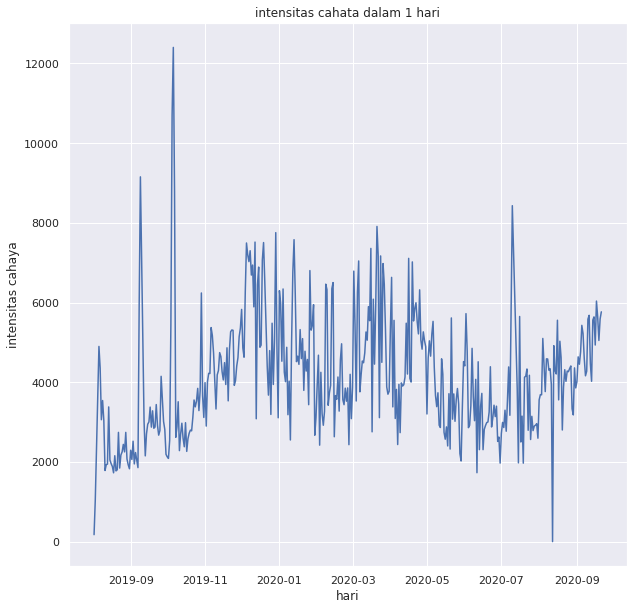

In [ ]:
# show the 1 day mean data (24 hours * 60 mins div 5 mins = 288 data each day)
plt.figure(figsize=(10,10))
plt.plot(df_resample['intensitas_cahaya'])
plt.title("intensitas cahata dalam 1 hari")
plt.xlabel("hari")
plt.ylabel("intensitas cahaya")
plt.show()

not yet


In [ ]:
# split the data into 0 as fraud and 1 as normal
# df['Target'] = df['intensitas_cahaya'] == 0
# df['Target'] = df['Target'] * 1
# df['Target']

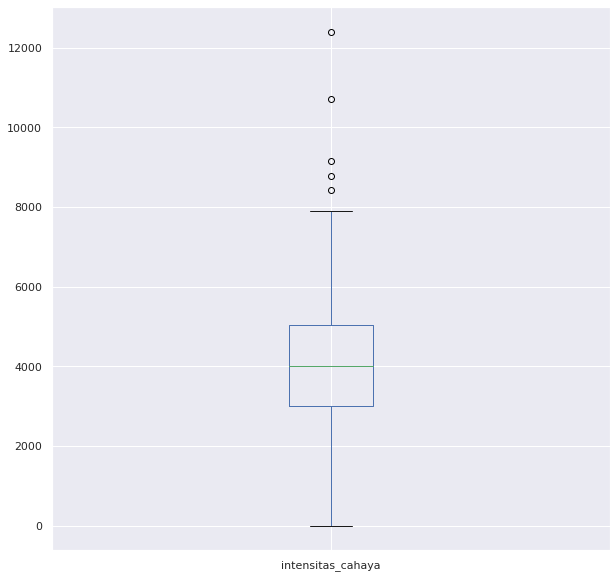

In [ ]:
df_resample['intensitas_cahaya'].plot(kind='box', figsize=(10, 10))
plt.show()

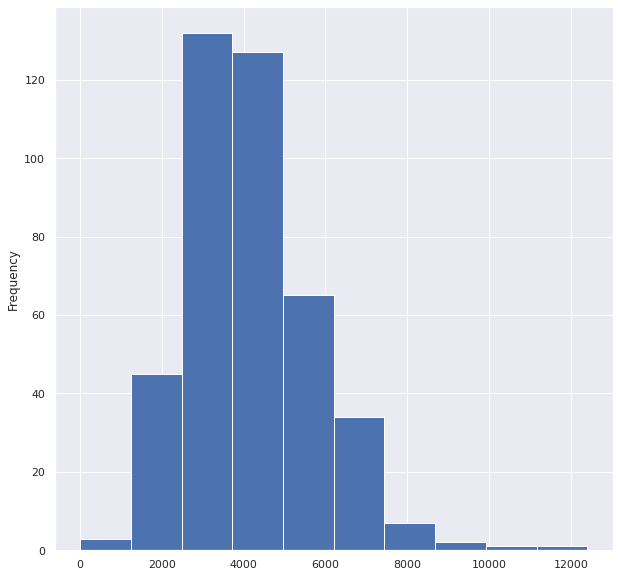

In [ ]:
df_resample['intensitas_cahaya'].plot(kind='hist', figsize=(10,10))
plt.show()

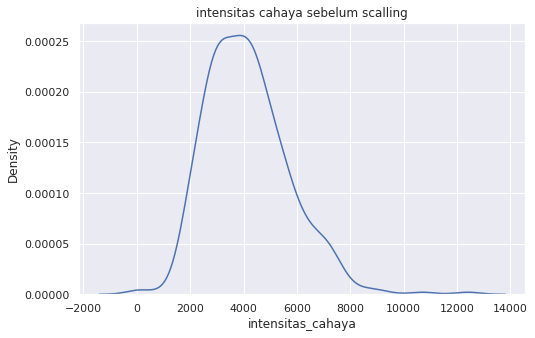

In [ ]:
fig, ax1 = plt.subplots(ncols=1, figsize=(8,5))
ax1.set_title('intensitas cahaya sebelum scalling')
sns.kdeplot(df_resample['intensitas_cahaya'], ax=ax1)
plt.show()

In [ ]:
# pre processing data
# df_resample = df_resample[['intensitas_cahaya']]

train_size = int(len(df_resample) * 0.80)
test_size = len(df_resample) - train_size
train, test = df_resample.iloc[0:train_size], df_resample.iloc[train_size:len(df_resample)]
print(train.shape, test.shape)

(333, 6) (84, 6)


In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(train[['intensitas_cahaya']])

train['intensitas_cahaya'] = scaler.transform(train[['intensitas_cahaya']])
test['intensitas_cahaya'] = scaler.transform(test[['intensitas_cahaya']])

print(test.shape, train.shape)

(126, 1) (291, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# helper function
def create_dataset(X, y, time_steps=1):
  a, b =[], []
  for i in range(len(X) - time_steps):
    v = X.iloc[i:(i + time_steps)].values
    a.append(v)
    b.append(y.iloc[i + time_steps])
  return np.array(a), np.array(b)

# create a sequence for 30 days long data
n_steps = 30

# reshapeing to 3D [n_samples, n_steps, n_features]

X_train, y_train = create_dataset(train[['intensitas_cahaya']], train['intensitas_cahaya'], n_steps)
X_test, y_test = create_dataset(test[['intensitas_cahaya']], test['intensitas_cahaya'], n_steps)
print(X_train.shape, X_test.shape)

(261, 30, 1) (96, 30, 1)


In [ ]:
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

epochs = 100
batch = 64
lr = 0.0001

In [ ]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 32)            6272      
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             33        
Total params: 15,905
Trainable params: 15,905
Non-trainable params: 0
____________________________________________________

In [ ]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train, X_train, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_test, X_test),
                                                ).history

Epoch 1/100
5/5 [==============================] - 5s 222ms/step - loss: 1.0073 - val_loss: 0.5904
Epoch 2/100
5/5 [==============================] - 0s 61ms/step - loss: 1.0098 - val_loss: 0.5899
Epoch 3/100
5/5 [==============================] - 0s 61ms/step - loss: 1.0211 - val_loss: 0.5894
Epoch 4/100
5/5 [==============================] - 0s 60ms/step - loss: 0.9798 - val_loss: 0.5892
Epoch 5/100
5/5 [==============================] - 0s 63ms/step - loss: 0.9630 - val_loss: 0.5891
Epoch 6/100
5/5 [==============================] - 0s 62ms/step - loss: 1.0018 - val_loss: 0.5885
Epoch 7/100
5/5 [==============================] - 0s 58ms/step - loss: 0.9998 - val_loss: 0.5882
Epoch 8/100
5/5 [==============================] - 0s 59ms/step - loss: 0.9989 - val_loss: 0.5879
Epoch 9/100
5/5 [==============================] - 0s 60ms/step - loss: 0.9743 - val_loss: 0.5879
Epoch 10/100
5/5 [==============================] - 0s 57ms/step - loss: 0.9849 - val_loss: 0.5878
Epoch 11/100
5/5 [

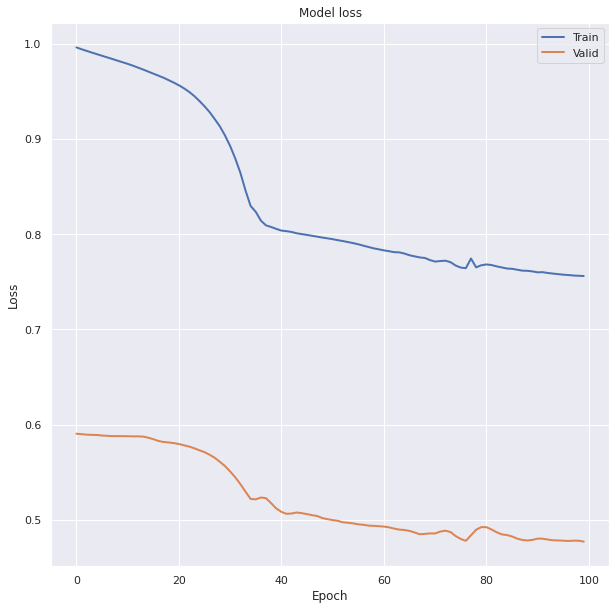

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

0.7360448200631802


<Figure size 1440x1440 with 0 Axes>

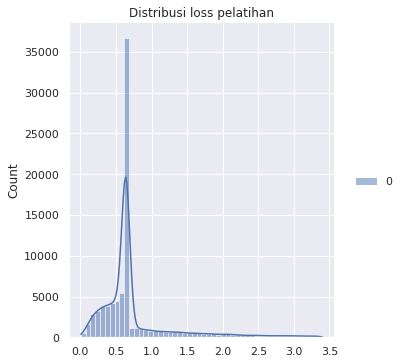

In [ ]:
train_pred = lstm_autoencoder.predict(X_train)
train_loss = (np.mean(np.abs(train_pred - X_train), axis=1))
avg_loss = train_loss.mean()
print(avg_loss)

# plotting
plt.figure(figsize=(20,20))
sns.displot(train_loss, bins=50, kde=True)
plt.title("Distribusi loss pelatihan")
plt.show()

In [ ]:
# MAE on the test data:
y_pred = lstm_autoencoder.predict(X_test)
print('Predict shape:', y_pred.shape); print();
mae = np.mean(np.abs(y_pred - X_test), axis=1)

# reshaping prediction
pred = y_pred.reshape((y_pred.shape[0] * y_pred.shape[1]), y_pred.shape[2])
print('Prediction:', pred.shape); print();
print('Test data shape:', X_test.shape); print();

# reshaping test data
X_test = X_test.reshape((X_test.shape[0] * X_test.shape[1]), X_test.shape[2])
print('Test data:', X_test.shape); print();

# error computation
errors = X_test - pred
print('Error:', errors.shape); print();

# rmse on test data
RMSE = np.sqrt(mean_squared_error(X_test, pred))
print('Test RMSE: %.3f' % RMSE)

Predict shape: (35942, 30, 1)

Prediction: (1078260, 1)

Test data shape: (35942, 30, 1)

Test data: (1078260, 1)

Error: (1078260, 1)

Test RMSE: 0.924


In [ ]:
dist = np.linalg.norm(X_test - pred, axis=1)

scores = dist.copy()
print('Score : ', scores.shape)
scores.sort()

cut_off = int(0.95 * len(scores))
print('cut off values : ', cut_off)

threshold = scores[cut_off]
print('Threshold values :', threshold)

Score :  (1078260,)
cut off values :  1024347
Threshold values : 1.907957632391073


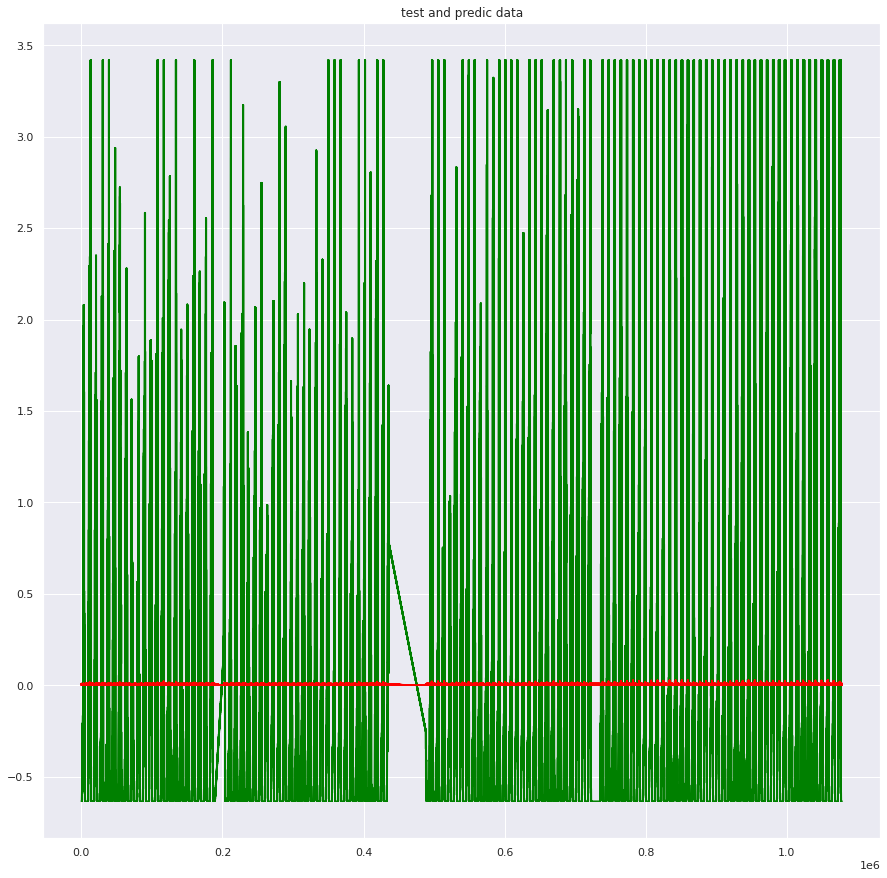

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(X_test, color='green')
plt.plot(pred, color='red')
plt.title('test and predic data')
plt.show()

In [ ]:
score = pd.DataFrame(index=test[n_steps:].index)
score['loss'] = mae
score['threshold'] = threshold
score['anomaly'] = score['loss'] > score['threshold']
score['intensitas_cahaya'] = test[n_steps:].intensitas_cahaya

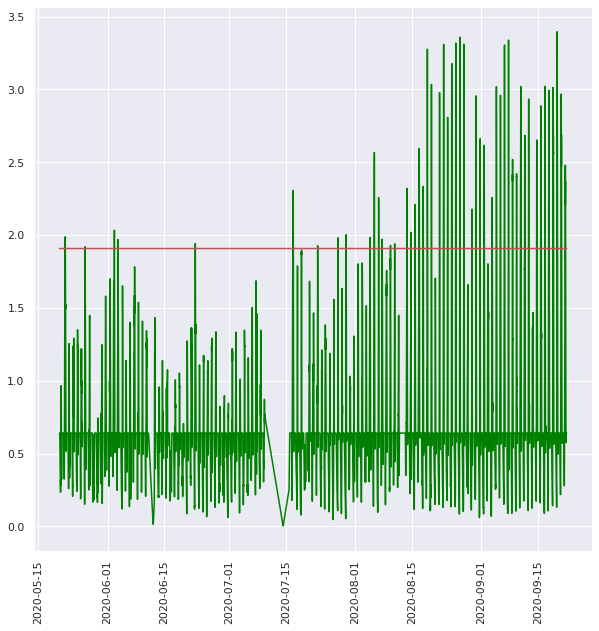

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(score.index, score['loss'], color='green', label='loss')
plt.plot(score.index, score['threshold'], color='r', label='threshold')
plt.xticks(rotation=90)
plt.show()

In [ ]:
anomalies = score[score['anomaly'] == True]
x = pd.DataFrame(anomalies.intensitas_cahaya)
x =pd.DataFrame(scaler.inverse_transform(x))
x.index = anomalies.index
x.rename(columns= {0: 'inverse_intensity'}, inplace=True)
anomalies = anomalies.join(x, how='left')
anomalies = anomalies.drop(columns=['intensitas_cahaya'], axis=1)
anomalies.count().sum()

5204

In [ ]:
test_inv = pd.DataFrame(scaler.inverse_transform(test[n_steps:]))
test_inv.index = test[n_steps:].index
test_inv.rename(columns={0: 'intensitas_cahaya'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


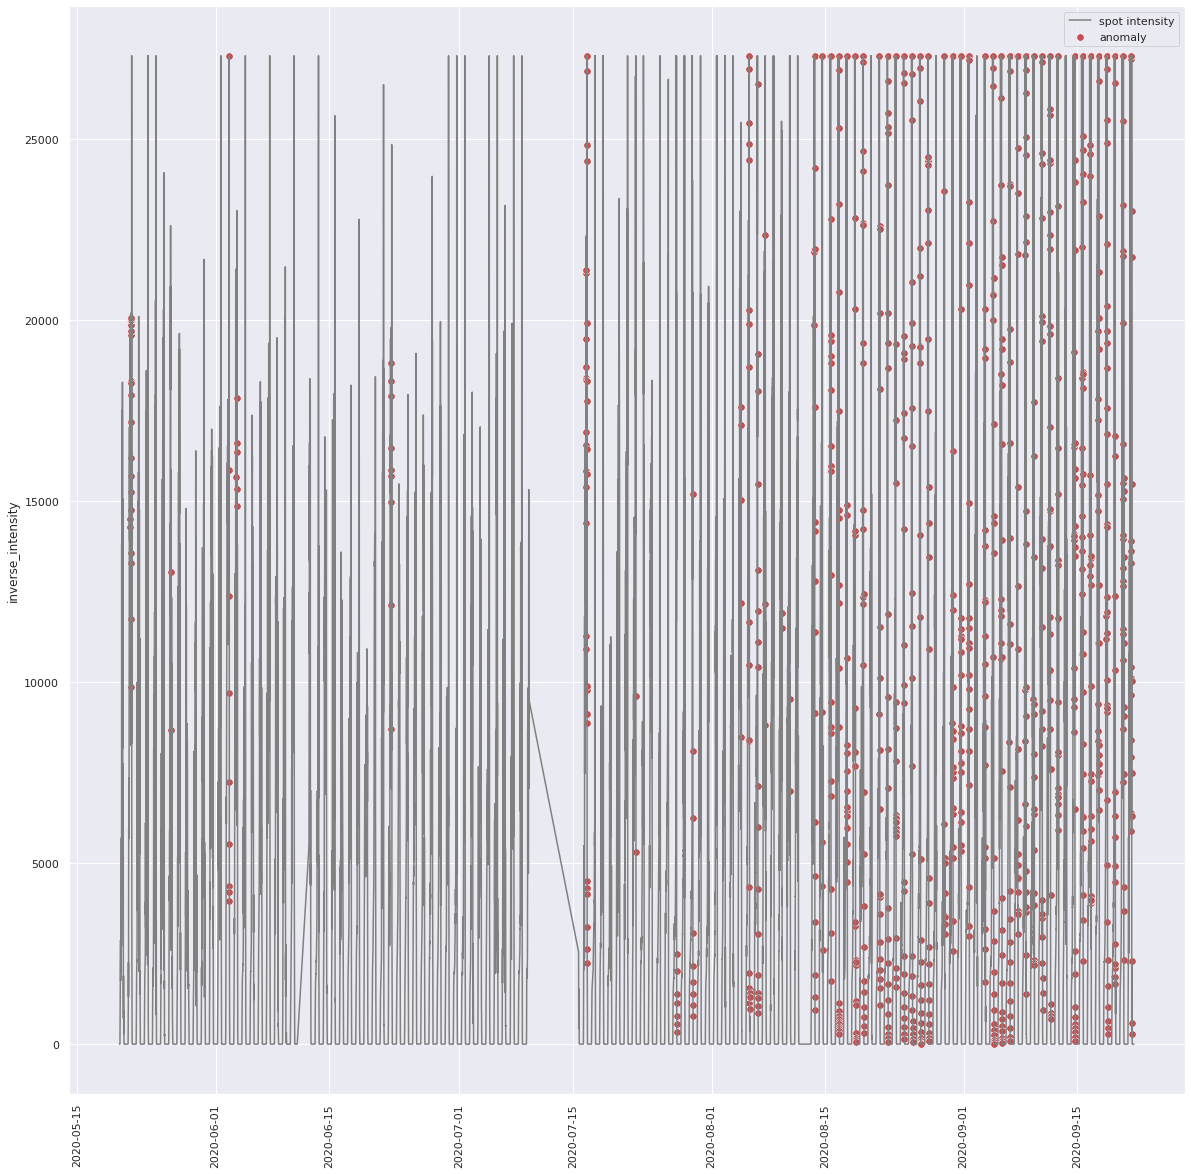

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(test_inv.index, test_inv.intensitas_cahaya, color='grey', label='spot intensity')
sns.scatterplot(anomalies.index, anomalies['inverse_intensity'], color=sns.color_palette()[3], s=55, label='anomaly')
plt.xticks(rotation=90)
plt.show()

bottom ide not yet

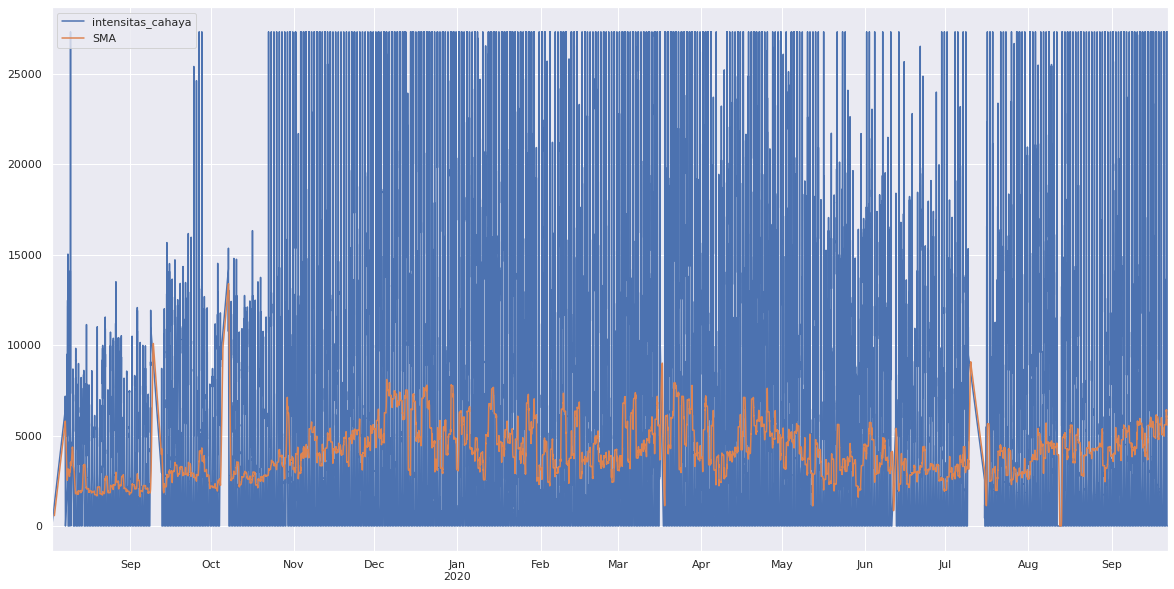

In [ ]:
# create simple moving average in one day
df['SMA'] = df.iloc[:,0].rolling(window=288).mean()
df['diff'] = df['intensitas_cahaya'] - df['SMA']
df[['intensitas_cahaya', 'SMA']].plot()
plt.show()

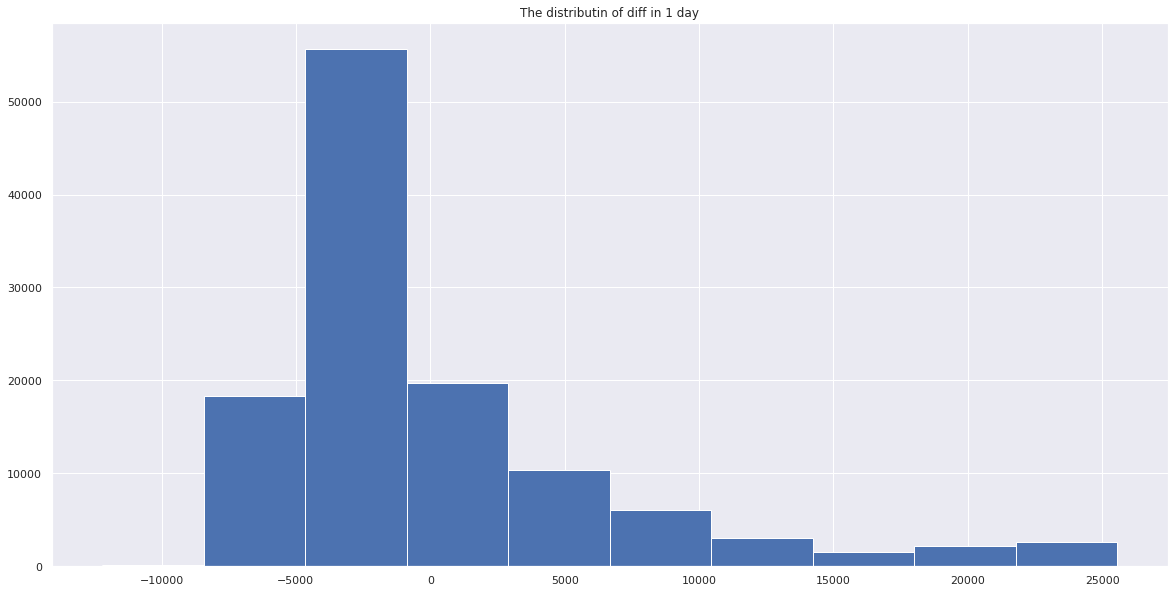

In [ ]:
df['diff'].hist()
plt.title('The distributin of diff in 1 day')
plt.show()

In [ ]:
df['SMA']

2019-08-02 15:05:00          NaN
2019-08-02 15:10:00          NaN
2019-08-02 15:15:00          NaN
2019-08-02 15:20:00          NaN
2019-08-02 15:25:00          NaN
                         ...    
2020-09-21 22:50:00    5586.5625
2020-09-21 22:55:00    5586.5625
2020-09-21 23:00:00    5586.5625
2020-09-21 23:05:00    5586.5625
2020-09-21 23:10:00    5586.5625
Freq: 5T, Name: SMA, Length: 119906, dtype: float64

In [ ]:
df.shape[1]

10

In [ ]:
df['upper'] = df['SMA'] + 5000
df['lower'] = df['SMA'] - 5000
df

,intensitas_cahaya,kelembaban_tanah,kelembaban_udara,suhu1,suhu2,ph,curah_hujan,Target,SMA,diff,upper,lower
2019-08-02 15:05:00,37.000000,16.490000,54.600000,27.810000,28.100000,6.280000,0.0,0,NaN,NaN,NaN,NaN
2019-08-02 15:10:00,24.000000,13.330000,54.400000,27.810000,28.200000,5.580000,0.0,0,NaN,NaN,NaN,NaN
2019-08-02 15:15:00,24.333333,13.147778,54.233333,27.713333,28.144444,5.603333,0.0,0,NaN,NaN,NaN,NaN
2019-08-02 15:20:00,24.666667,12.965556,54.066667,27.616667,28.088889,5.626667,0.0,0,NaN,NaN,NaN,NaN
2019-08-02 15:25:00,25.000000,12.783333,53.900000,27.520000,28.033333,5.650000,0.0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21 22:50:00,0.000000,34.260000,99.900000,20.630000,21.800000,7.390000,0.0,1,5586.5625,-5586.5625,10586.5625,586.5625
2020-09-21 22:55:00,0.000000,54.090000,99.900000,20.500000,21.700000,7.390000,0.0,1,5586.5625,-5586.5625,10586.5625,586.5625
2020-09-21 23:00:00,0.000000,36.110000,99.900000,20.690000,21.400000,7.390000,0.0,1,5586.5625,-5586.5625,10586.5625,586.5625
2020-09-21 23:05:00,0.000000,37.630000,99.900000,21.060000,21.400000,7.390000,0.0,1,5586.5625,-5586.5625,10586.5625,586.5625
